In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/SecondCompetition

/gdrive/My Drive/SecondCompetition


In [ ]:
import os
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#import visualkeras

tfk = tf.keras
tfkl = tfk.layers

## IMPORTING DATA

In [ ]:
df = pd.read_csv('Training.csv')
df.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


## DATA PREPARATION

Let's divide data in training and validation. Let's normalize the datasets.

In [ ]:
col_ind = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

num_features = df.shape[1]

#Normalization
train_mean = train_df.mean()
train_std = train_df.std()

X_train = (train_df - train_mean) / train_std
X_val = (val_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Features', value_name='Normalized')

#Violin Plot 
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Features', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

## WINDOW GENERATOR

Let's create a class that well'use to generate the sequences of data.

In [ ]:
class WindowGenerator(): 
  def __init__(self, input_width, label_width, shift,
               train_df=X_train, val_df=X_val,
               feature_columns=None):
    #Takes as input:
    # - input_width = sequenza in input (window size)
    # - label_width = sequenza di label da prevedere (telescope)
    # - shift = dopo quanti valori prendere la label sequence (spazio tra fine window e inizio telescope)
    # - train_df=train_df, val_df=val_df : dataframes
    # - feature_columns=None : quali feature
               
    
    # Store the raw data
    self.train_df = train_df
    self.val_df = val_df

    # Se feature_columns è fornito come parametro, verrano restituite come output solo quelle colonne
    self.feature_columns = feature_columns
    if feature_columns is not None:
      self.feature_columns_indices = {name: i for i, name in
                                    enumerate(feature_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    ## per restituire valori considerati
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Feature column name(s): {self.feature_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=10, shift=10)
                     #feature_columns=['Crunchiness'])
w1

Total window size: 34
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33]
Feature column name(s): None

Aggiungiamo alla classe una funzione "split_window" che data una sequenza di dati in input, li divida in 
- input sequence, lunga input_width
- label sequence, lunga label_width, shiftata di parametro shift.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.feature_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.feature_columns],
        axis=-1)
    
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Scriviamo ora una funzione per rappresentare questi dati:

In [ ]:
def plot(self, model=None, plot_col='Crunchiness', max_subplots=3):
  inputs, labels = self.example # si può anche scrivere come w2.example = w2.split_window(self.example)
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.feature_columns:
      label_col_index = self.feature_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Creiamo ora una funzione che crei il nostro tensore con i dati divisi in batch

In [ ]:
BATCH_SIZE=50
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
#WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 576
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

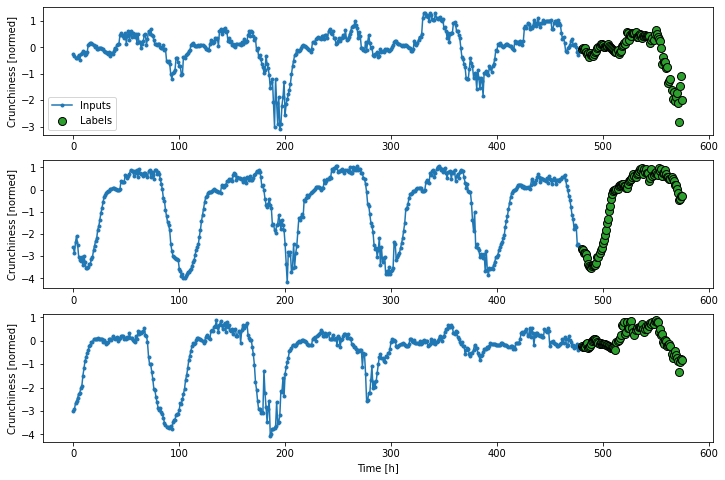

In [ ]:
IN_STEPS = 480
OUT_STEPS = 96
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Inseriamo la funzione create_folders_and_callbacks

In [ ]:
# Utility function to create folders and callbacks for training
 #it is a function you apply at a certain time of your train, to save a "check_point"

from datetime import datetime

def create_folders_and_callbacks(model_name, patience_es = 10, patience_lr = 5): 

  exps_dir = os.path.join('EL_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tfk.callbacks.ModelCheckpoint(
      filepath = os.path.join(ckpt_dir, 'cp.ckpoint'), 
      save_weights_only = False,
      save_best_only = False, #the purpose is to start from the current epoque not from the best epoque
  )
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True)
  callbacks.append(es_callback)
    
  reduce_plateau = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   mode='min', 
                                                   patience=patience_lr, 
                                                   factor=0.5, 
                                                   min_lr=1e-5)
  callbacks.append(reduce_plateau)
  

  return callbacks

## MODEL DEFINITION

In [ ]:
input_shape = (480,7)
output_shape = (96,7)

Creiamo un modello sequence-to-sequence basato su GRU LAYERS.

In [ ]:
# n_hidden = 200
def build_model(input_shape,output_shape):

  input_layer = tfkl.Input(shape=input_shape, name='Input')

  encoder_last_h, encoder_last_s = tfkl.GRU(200, activation='elu', dropout=0.2, recurrent_dropout=0.2,
                                                          return_sequences=False, return_state=True)(input_layer)
  
  encoder_last_h = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h)
  encoder_last_s = tfkl.BatchNormalization(momentum=0.6)(encoder_last_s)

  decoder = tfkl.RepeatVector(output_shape[-2])(encoder_last_h)
  decoder = tfkl.GRU(200, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
      decoder, initial_state = encoder_last_h)
  
  output_layer = tfkl.TimeDistributed(tfkl.Dense(output_shape[-1]))(decoder)

  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

  # the loss function is the mean squared error -> can ginve an idea of error average

  # Return the model
  return model



In [ ]:
model = build_model(input_shape, output_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 480, 7)]     0           []                               
                                                                                                  
 gru (GRU)                      [(None, 200),        125400      ['Input[0][0]']                  
                                 (None, 200)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 200)         800         ['gru[0][0]']                    
 alization)                                                                                       
                                                                                              

In [ ]:
window = multi_window

history = model.fit(
    x = window.train,
    validation_data = window.val,
    batch_size = BATCH_SIZE,
    epochs = 200,
    callbacks =  create_folders_and_callbacks('seq2seq_GRU')
).history

Epoch 1/200
1085/1085 [==============================] - ETA: 0s - loss: 0.4112 - mae: 0.4592

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2681s 2s/step - loss: 0.4112 - mae: 0.4592 - val_loss: 0.5152 - val_mae: 0.4964 - lr: 0.0010
Epoch 2/200
1085/1085 [==============================] - ETA: 0s - loss: 0.2451 - mae: 0.3525

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2676s 2s/step - loss: 0.2451 - mae: 0.3525 - val_loss: 0.5721 - val_mae: 0.5139 - lr: 0.0010
Epoch 3/200
1085/1085 [==============================] - ETA: 0s - loss: 0.1964 - mae: 0.3155

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2720s 3s/step - loss: 0.1964 - mae: 0.3155 - val_loss: 0.6441 - val_mae: 0.5537 - lr: 0.0010
Epoch 4/200
1085/1085 [==============================] - ETA: 0s - loss: 0.1584 - mae: 0.2846

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2772s 3s/step - loss: 0.1584 - mae: 0.2846 - val_loss: 0.6422 - val_mae: 0.5543 - lr: 0.0010
Epoch 5/200
1085/1085 [==============================] - ETA: 0s - loss: 0.1326 - mae: 0.2609

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2780s 3s/step - loss: 0.1326 - mae: 0.2609 - val_loss: 0.6358 - val_mae: 0.5481 - lr: 0.0010
Epoch 6/200
1085/1085 [==============================] - ETA: 0s - loss: 0.1190 - mae: 0.2467

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2772s 3s/step - loss: 0.1190 - mae: 0.2467 - val_loss: 0.6080 - val_mae: 0.5365 - lr: 0.0010
Epoch 7/200
1085/1085 [==============================] - ETA: 0s - loss: 0.0956 - mae: 0.2215

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2775s 3s/step - loss: 0.0956 - mae: 0.2215 - val_loss: 0.6121 - val_mae: 0.5349 - lr: 5.0000e-04
Epoch 8/200
1085/1085 [==============================] - ETA: 0s - loss: 0.0907 - mae: 0.2152

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2808s 3s/step - loss: 0.0907 - mae: 0.2152 - val_loss: 0.6088 - val_mae: 0.5378 - lr: 5.0000e-04
Epoch 9/200
1085/1085 [==============================] - ETA: 0s - loss: 0.0873 - mae: 0.2107

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2823s 3s/step - loss: 0.0873 - mae: 0.2107 - val_loss: 0.5992 - val_mae: 0.5315 - lr: 5.0000e-04
Epoch 10/200
1085/1085 [==============================] - ETA: 0s - loss: 0.0840 - mae: 0.2062

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2826s 3s/step - loss: 0.0840 - mae: 0.2062 - val_loss: 0.6155 - val_mae: 0.5361 - lr: 5.0000e-04
Epoch 11/200
1085/1085 [==============================] - ETA: 0s - loss: 0.0802 - mae: 0.2014

INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


INFO:tensorflow:Assets written to: EL_experiments/seq2seq_GRU_Jan19_10-16-42/ckpts/cp.ckpoint/assets


1085/1085 [==============================] - 2828s 3s/step - loss: 0.0802 - mae: 0.2014 - val_loss: 0.6323 - val_mae: 0.5469 - lr: 5.0000e-04


In [ ]:
model.save('model_480_96_seq2seq_GRU_200')

INFO:tensorflow:Assets written to: model_480_96_seq2seq_GRU_200/assets


INFO:tensorflow:Assets written to: model_480_96_seq2seq_GRU_200/assets


*Source: Tensorflow tutorial for Time Series Forecasting*